In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [4]:
import cupy as cp

In [5]:
PROJECT_PATH = '../'
SRBF_PATH = "/scratch/ceph/swei20/data/dnn/BHB/rbf_Blue_R2300_1k.h5"
BLUE_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_Blue_R2300.h5"
REDM_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_RedM_R5000.h5"
sys.path.insert(0, PROJECT_PATH)

### Load data

In [6]:
with h5py.File(BLUE_PATH, 'r') as f:
    flux0 = f['flux'][()]
    para0 = f['para'][()]
    wave0 = f['wave'][()]

In [7]:
flux0.shape, wave0.shape

((116614, 5368), (5368,))

In [8]:
from lv.base.dataloader_c import DataLoader

In [9]:
ds = DataLoader()

In [10]:
ds.prepare_data ("Blue", "B", flux0, wave0, para0, fix_CO=0)

flux: 3300, wave: 5368


# find mask

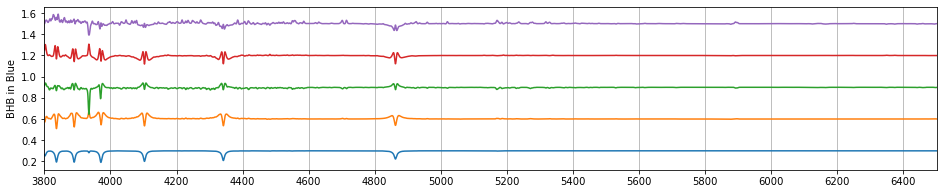

In [11]:
ds.init_pcp()

In [12]:
ds.flux.shape

(3300, 5368)

In [16]:
_,w,v =cp.linalg.svd(ds.flux, full_matrices=0)

(0.0, 25.0)

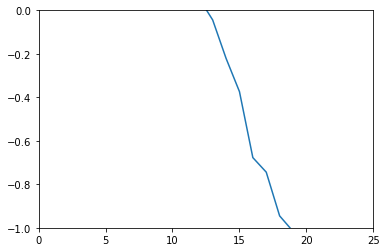

In [22]:
plt.plot(np.log(cp.asnumpy(w)))
plt.ylim(-1,0)
plt.xlim(0,25)

In [33]:
# k,q,prom = 10, 0.75, 0.1
k,q,prom = 5, 0.8, 0.01
peaks, prop, nvv= ds.get_peaks(k=k,q=q,prom=prom)

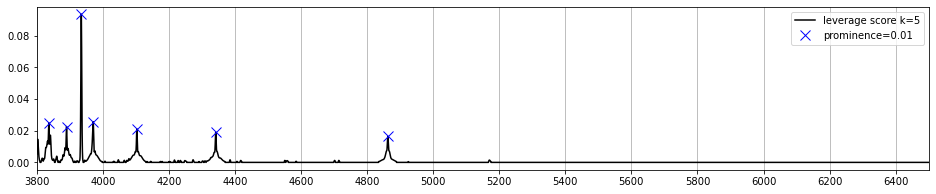

In [34]:
ds.plot_peaks(nvv, peaks, k, prom)

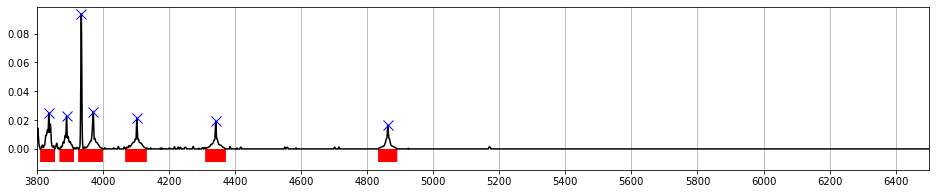

In [35]:
ds.plot_mask_from_peaks(peaks, prop, nvv)

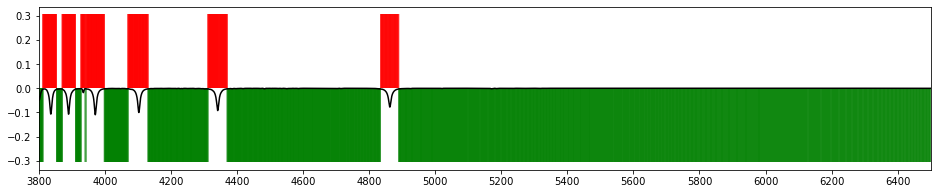

In [36]:
ds.plot_MN_mask(0)

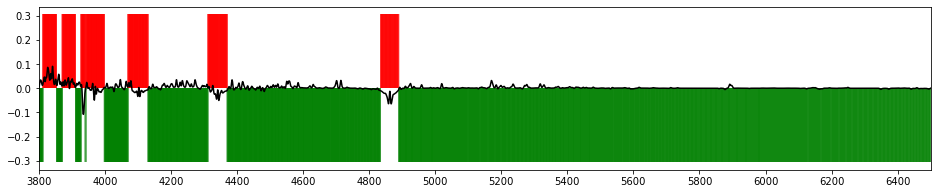

In [37]:
ds.plot_MN_mask(4)

In [39]:
# ds.plot_lick()

In [40]:
ds.get_MN(ds.nmask, top=5)

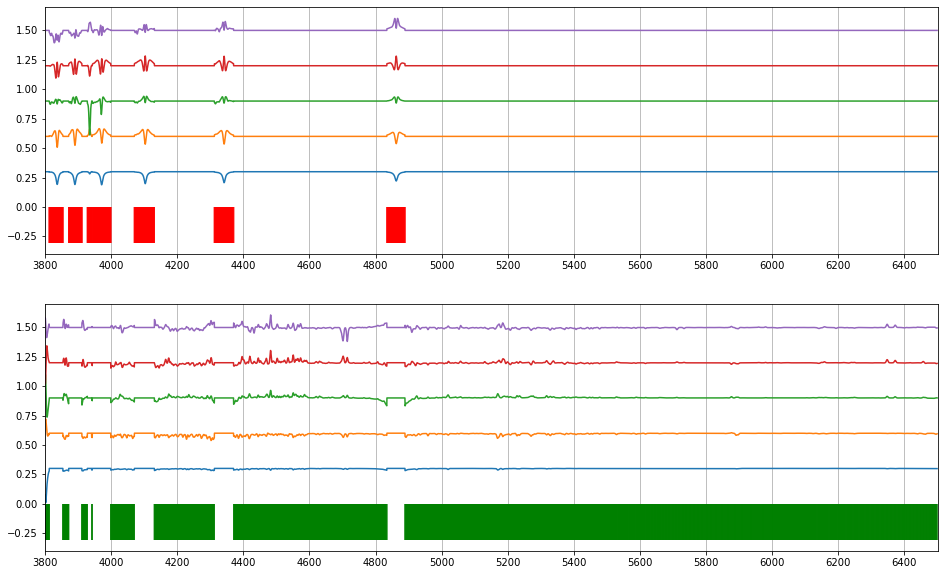

In [41]:
ds.plot_MN(step=0.3)

In [46]:
mu = 1.0 / ds.Mw[2]
ML, MS, MLv, MSv = ds._pcp(ds.M, delta=1e-5, mu=mu, lam=None, norm=None, maxiter=1000)

mu 0.03, lambda 0.0174, norm 465616.8


L(31, 780), S(30, 780)


(31, 5368)


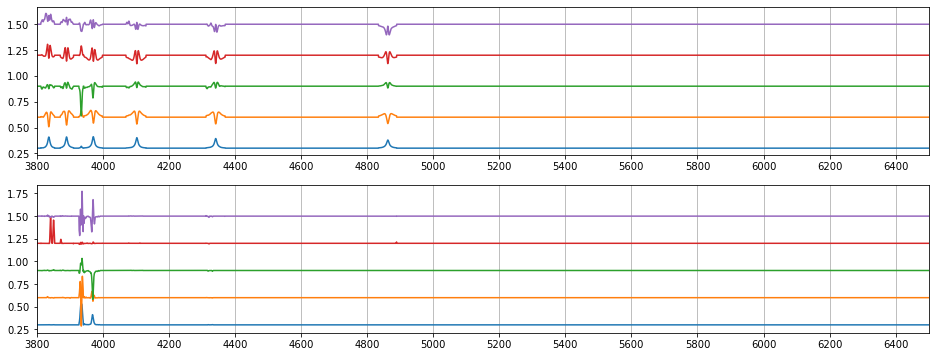

In [48]:
nMLv, nMSv =ds.eval_pcp(MLv, MSv)

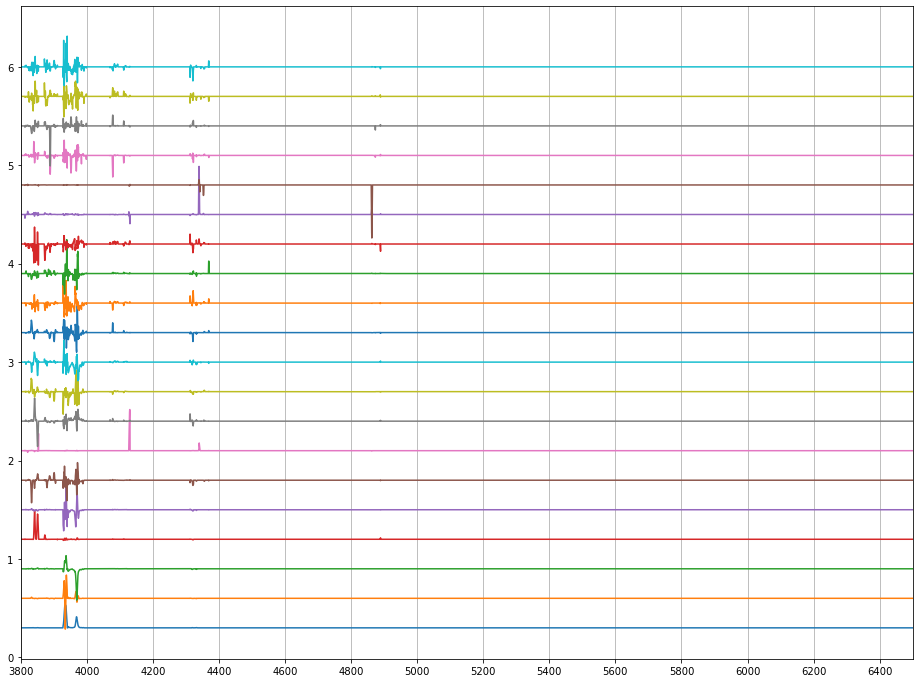

In [49]:
ds.plot_V(nMSv, top=20)

In [52]:
mu = 1.0 / ds.Nw[2]
NL, NS, NLv, NSv = ds._pcp(ds.N, delta=1e-6, mu=mu, lam=None, norm=None, maxiter=1000)

mu 0.12, lambda 0.0174, norm 13353.8


L(61, 4588), S(30, 4588)


(61, 5368)


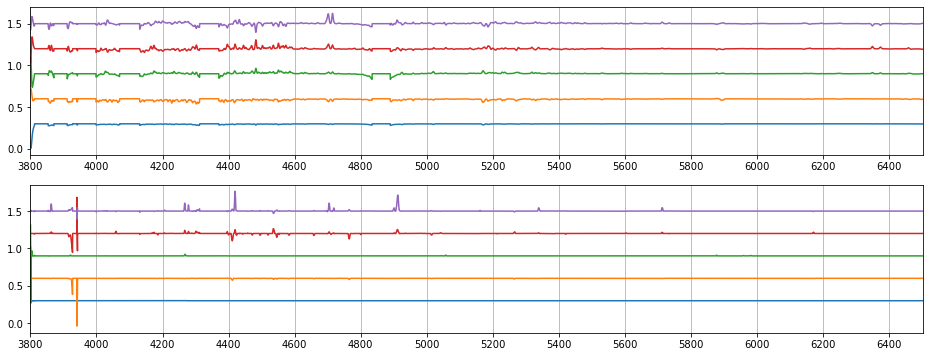

In [53]:
nNLv, nNSv = ds.eval_pcp(NLv, NSv, isM=0)

In [54]:
ds.pcp_transform(MLv, MSv, NLv, NSv, top=20)

In [55]:
ds.pcp_np(save=1)

In [56]:
ds.npcpFlux.shape

(3300, 80)

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [59]:
rf = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=100, max_features=30)

In [61]:
ds.npcpFlux.shape

(3300, 80)

In [62]:
idx=1
rf.fit(ds.npcpFlux[:,:40], ds.para[:,idx])

RandomForestRegressor(max_depth=50, max_features=30, random_state=0)

In [65]:
ds.pnames=["Teff", "Logg", "[M/H]", "[C/M]", "[a/M]"]

In [76]:
rf.feature_importances_.argsort()[::-1]

array([28, 32,  4, 22, 20, 35, 18,  8, 27, 34, 39, 29, 37, 30,  1, 15, 33,
        3, 31, 24,  0, 36, 21,  5, 38, 23, 25, 26, 10, 11,  6, 17,  7, 19,
        2, 14,  9, 12, 16, 13])

Text(0.5, 1.0, 'log feature importance for Logg')

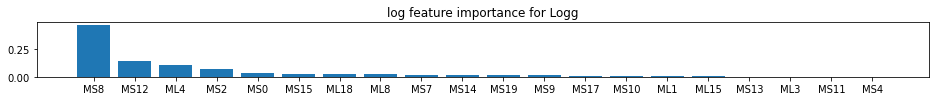

In [78]:
sdx = rf.feature_importances_.argsort()[::-1][:20]
plt.figure(figsize=(16,1), facecolor="w")
plt.bar([ds.Xname[sdx[i]] for i in range(len(sdx))], rf.feature_importances_[sdx], log=0)
plt.title(f"log feature importance for {ds.pnames[idx]}")

In [89]:
ds.nXv.shape

(80, 5368)

In [232]:
# plt.figure(figsize=(16,1))
# plt.vlines(ds.nwave[ds.nmask], ymin=0,ymax=0.1,color='r')
# ds.get_wave_axis(ax=plt.gca())
# ds.plot_lick()


In [247]:
a = 

In [249]:
import re

In [299]:
a = lines[3]

In [300]:
re.split("\s+", a)

['',
 '390.0071',
 '1.052',
 '28.02',
 '226380.360',
 '7.0',
 '(4F)5d',
 '5H',
 '200747.060',
 '6.0',
 '(4F)5p',
 '5G',
 '8.95',
 '-6.05',
 '-7.64K88',
 '0',
 '0',
 '0',
 '0.000',
 '0',
 '0.000',
 '0',
 '0',
 '1286',
 '1334',
 '']

In [295]:
a= a.split(" ")

In [297]:
a.strip()

AttributeError: 'list' object has no attribute 'strip'

In [327]:
a = line.split(" ")[0]

In [329]:
float(a)

399.9968

In [338]:
n=3
with open("/scratch/ceph/szalay/swei20/LL/kurucz/gf0400.10") as f:
    lines = f.readlines()
    mat = np.zeros((len(lines), n))
    for ii, line in enumerate(lines[1:]): 
        line=re.split("\s+", line)[1:4]
        for nn, ll in enumerate(line):
            mat[ii,nn] = float(ll)
#         line = "".join([ll + " " for ll in line])
    
    
#     for i in f:
#         text += i.replace("\D","")
#         print(i)
#         break
#     text = re.sub('\D','', f)

In [339]:
mat

array([[390.0018,  -5.061 ,  22.    ],
       [390.0056,  -1.334 ,  29.01  ],
       [390.0071,   1.052 ,  28.02  ],
       ...,
       [399.9964,  -3.831 ,  24.01  ],
       [399.9968,  -3.812 ,  20.    ],
       [  0.    ,   0.    ,   0.    ]])

In [ ]:
pd.DataFrame(mat, column=)

In [118]:
sdx

array([28, 32,  4, 22, 20, 35, 18,  8, 27, 34, 39, 29, 37, 30,  1, 15, 33,
        3, 31, 24])

(0.1, 0.15595319947079092)

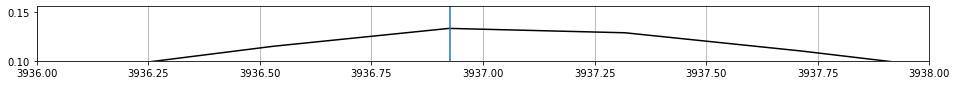

In [132]:
ds.plot_nv(nMSv, 2,fineW=1)
plt.axvline(3936.9264, c="")
plt.xlim(3936,3938)
plt.ylim(0.1, None)

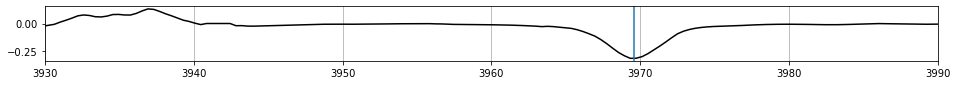

In [193]:
ds.plot_nv(nMSv, 2,fineW=1)
plt.xlim(3930,3990)
plt.axvline(3969.59 , label="Ca II" )

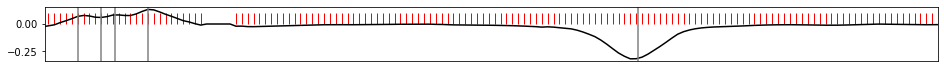

In [182]:

ds.plot_nv(nMSv, 2,fineW=1)
# plt.ylim(0.0, 0.1)
ds.plot_mask(ds.nmask,ax=plt.gca())
plt.xlim(3930,3990)
plot_lines()

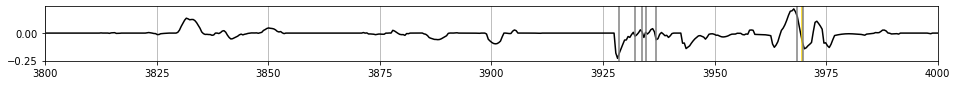

In [235]:
# ds.plot_mask(ds.nmask, fineW=1)
ds.plot_nv(nMSv, 8,fineW=1)
# plt.ylim(0.0, 0.1)
plt.xlim(3800,4000)
plt.vlines([],ymin=-0.25,ymax=0.2)

# plot_lines()

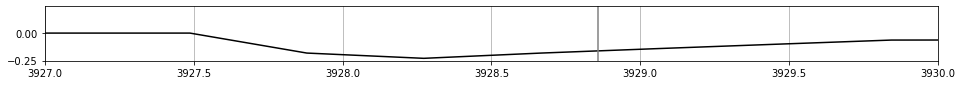

In [190]:
# ds.plot_mask(ds.nmask, fineW=1)
ds.plot_nv(nMSv, 8,fineW=1)
# plt.ylim(0.0, 0.1)
plt.xlim(3927,3930)
# plot_lines()
ax=plt.gca()
ax.axvline(3928.86 , c="gray", label="Fe I")


In [206]:
def plot_lines(ax=None):
    if ax is None: ax=plt.gca()
    ax.axvline(3928.57, c="gray", label="Fe I")
    ax.axvline(3969.59 , c="gold", label="Ca II" )    
    ax.axvline(3936.9264, c="gray", label="Fe I")
    ax.axvline(3969.84, c="gray", label="Fe III")
    ax.axvline(3932.23, c="gray", label="Fe I")
    ax.axvline(3933.74, c="gray", label="Fe I")
    ax.axvline(3934.72, c="gray", label="Fe I")
    ax.axvline(3968.5429, c="gray", label="Fe I")

        

(3900.0, 4000.0)

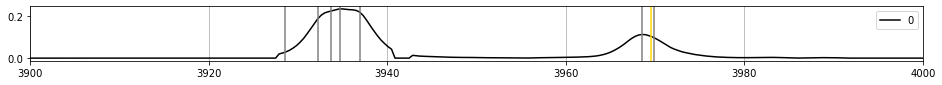

In [210]:
ds.plot_nv(nMSv, 0,fineW=1)
plt.legend()
# plot_lines()
plt.xlim(3900,4000)
ax.axvline(3934.72, c="gray", label="Fe I")
ax.axvline(3968.5429, c="gray", label="Fe I")
# plt.xlim(3964,3972)

# plt.ylim(0.0,0.12)

(3900.0, 4000.0)

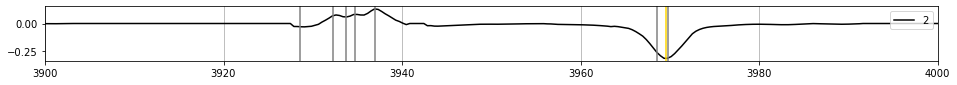

In [213]:
ds.plot_nv(nMSv, 2,fineW=1)
plt.legend(loc=1)
plot_lines()
plt.xlim(3900,4000)
# plt.ylim(-0.32,-0.3)

In [ ]:
ds.plot_nv(nMSv, 8,fineW=1)
plt.legend(loc=1)
# plot_lines()
plt.vlines([3924.59,3931.98,3934.77,3936.4,3947.16,3950.02,3950.722,3958.17,3969.59,3973.69,3974.83],ymin=-0.25,ymax=0.2)
plt.xlim(3900,4000)

(3900.0, 4000.0)

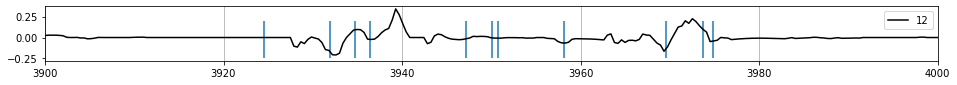

In [231]:
ds.plot_nv(nMSv, 12,fineW=1)
plt.legend(loc=1)
# plot_lines()
# plt.axvline(4369.12)
# plt.axvline(4368.8)

# plt.vlines([3934, 3968],ymin=-0.25,ymax=0.2)
plt.vlines([3924.59,3931.98,3934.77,3936.4,3947.16,3950.02,3950.722,3958.17,3969.59,3973.69,3974.83],ymin=-0.25,ymax=0.2)
plt.xlim(3900,4000)
# plt.ylim(-0.,0.15)

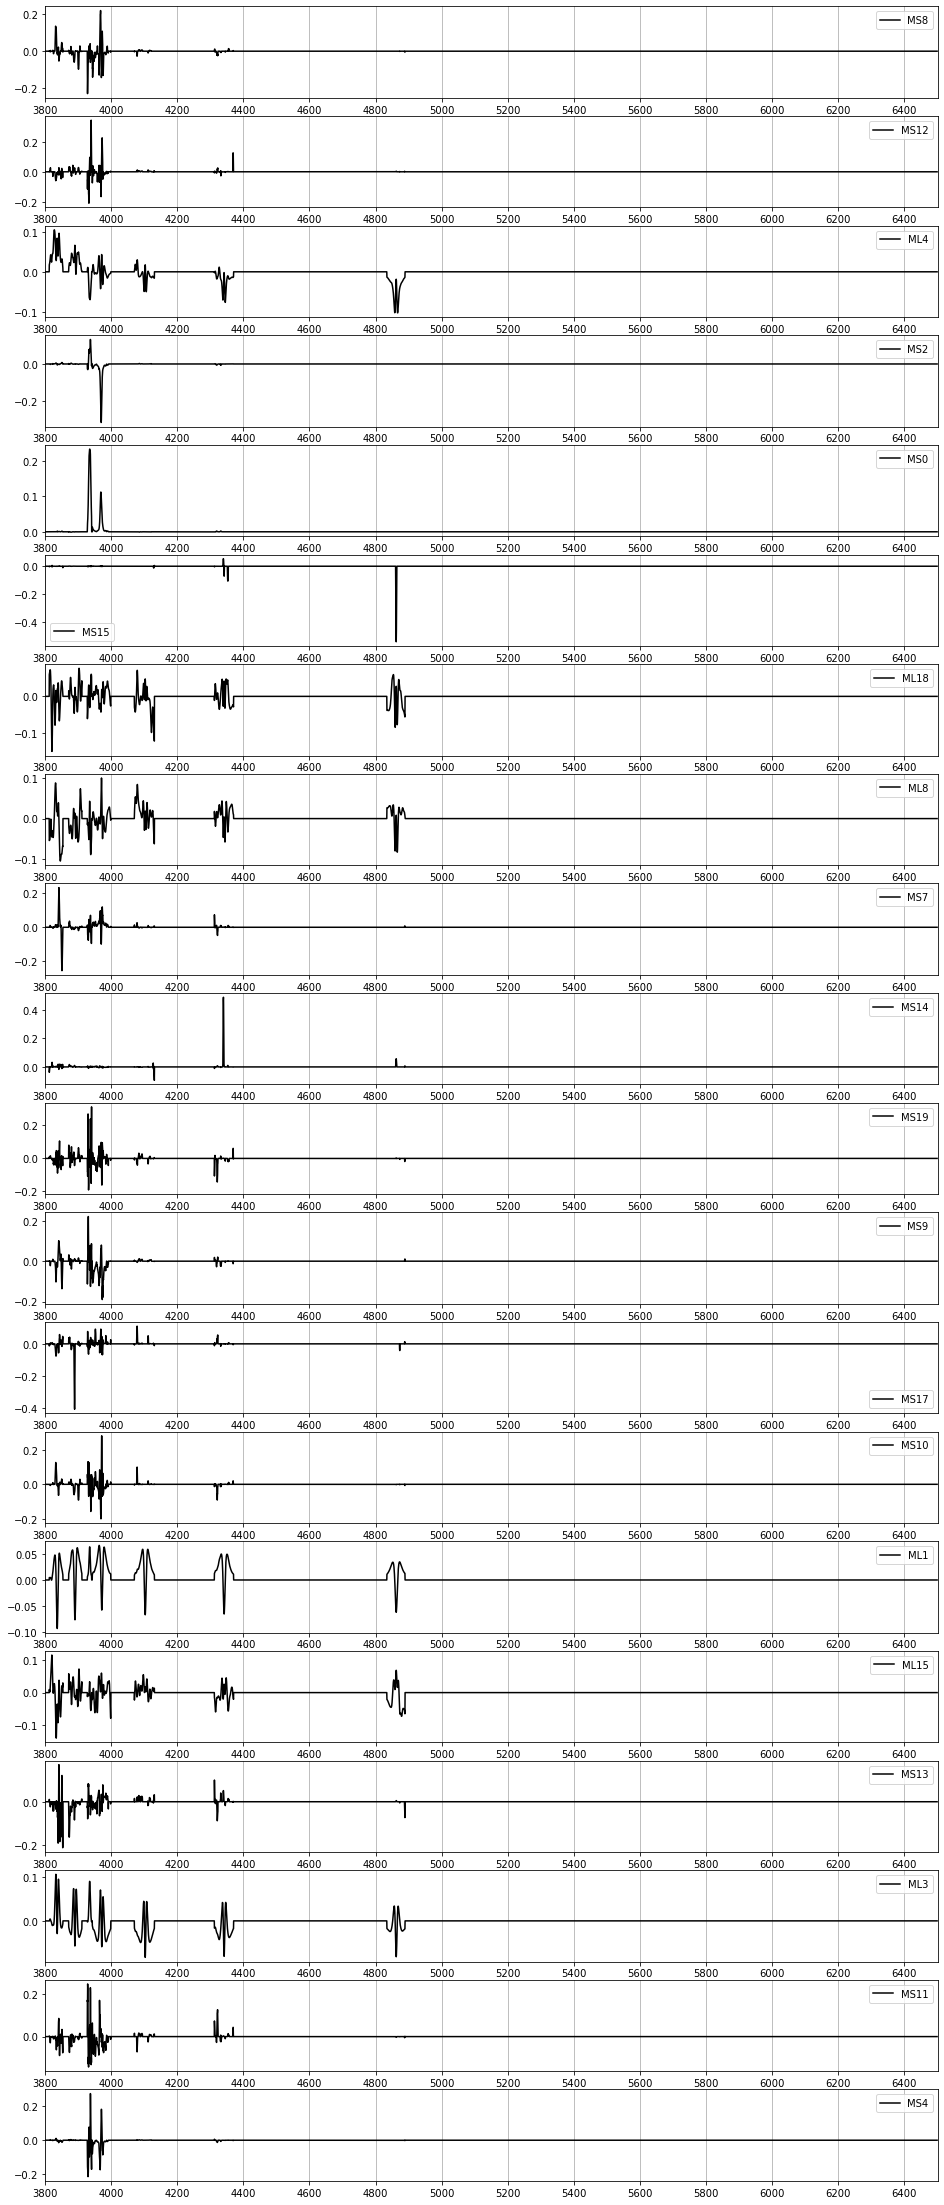

In [119]:
ds.plot_nvs(ds.nXv, sdx, nidxs=ds.Xname)

/home/swei20/LV/nb/../lv/base/dataloader_c.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  v = nvs[idx]


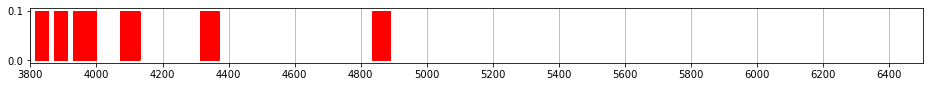

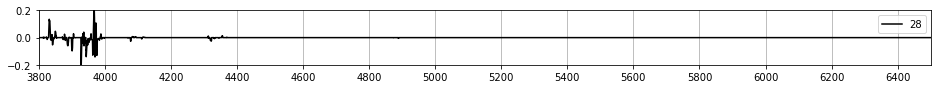

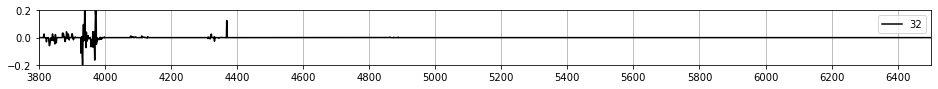

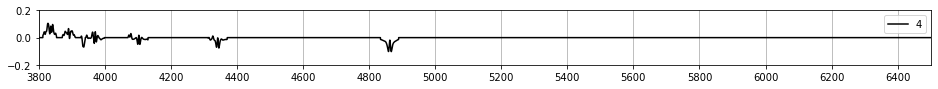

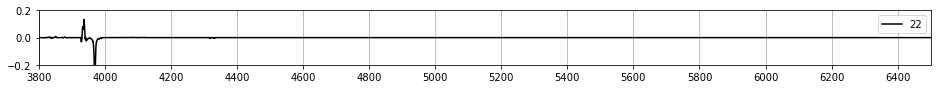

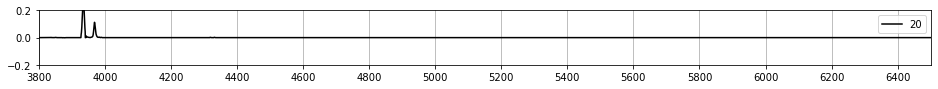

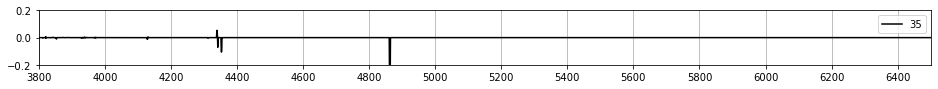

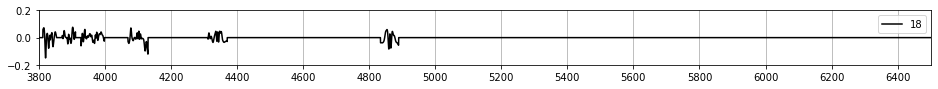

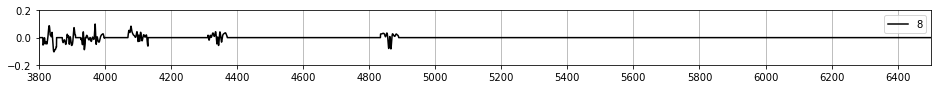

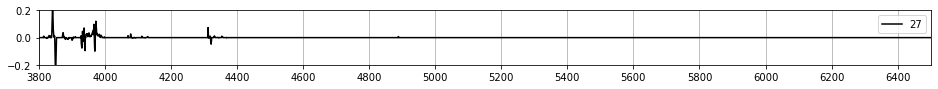

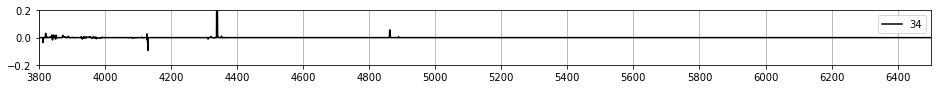

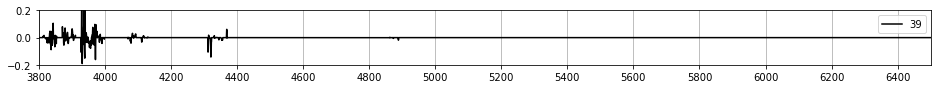

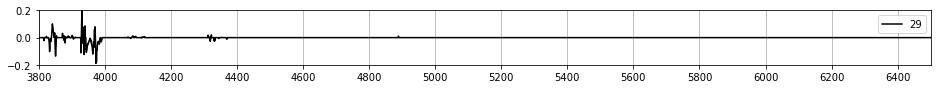

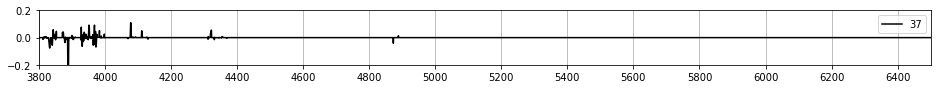

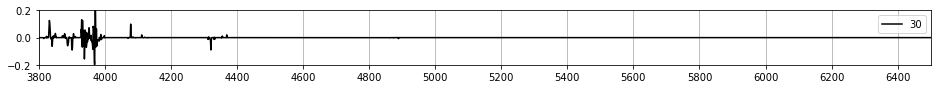

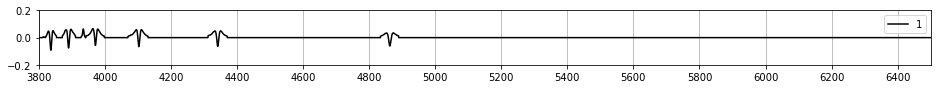

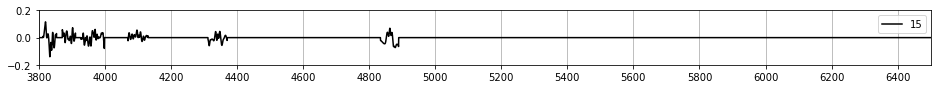

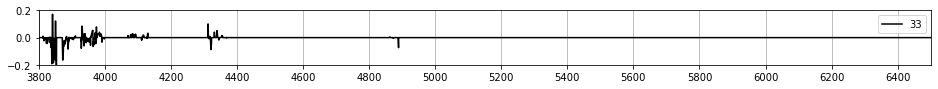

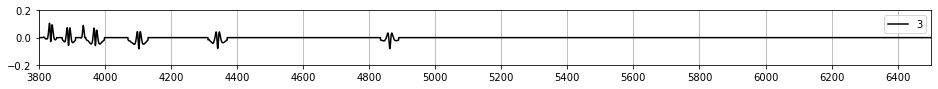

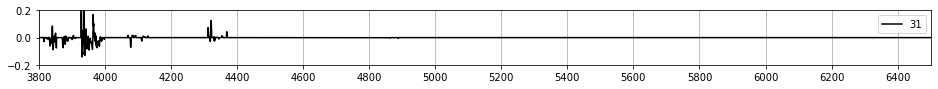

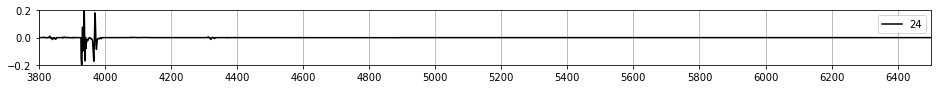

In [103]:
ds.plot_mask(ds.nmask)
for i in range(20):
    ds.plot_nv(ds.nXv, sdx[i])
    plt.ylim(-0.2,0.2)
    plt.legend()

(3800.0, 4000.0)

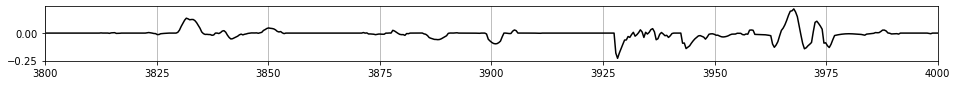

In [84]:
ds.plot_nv(nMSv, 8, fineW=1)
plt.xlim(3800, 4000)

(3800.0, 4000.0)

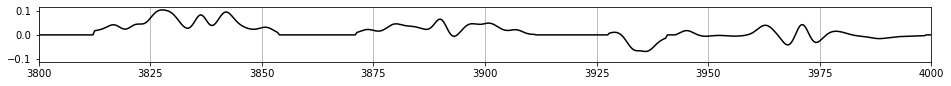

In [88]:
ds.plot_nv(nMLv, 4, fineW=1)
plt.xlim(3800, 4000)

(3800.0, 4000.0)

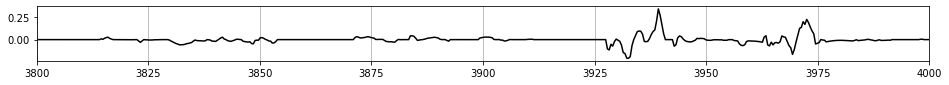

In [85]:
ds.plot_nv(nMSv, 12, fineW=1)
plt.xlim(3800, 4000)

In [ ]:
for i in range(60):
#     idx = a[:,5:25].reshape(-1)
    ds.plot_nv(ds.nXv, s[i])
    plt.legend()

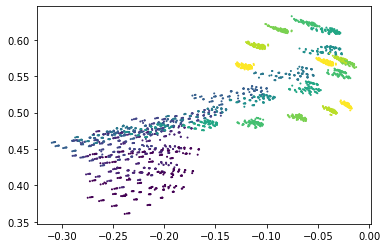

In [87]:
plt.scatter(ds.npcpFlux[:,sdx[0]], ds.npcpFlux[:, sdx[1]],  c=ds.para[:,idx],s=1)

In [74]:
sdx

array([13, 16, 12,  9, 14,  2, 19,  7, 17,  6, 11, 10, 26, 25, 23, 38,  5,
       21, 36,  0])

In [ ]:
plt.scatter(ds.npcpFlux[:,sdx[-1]], ds.npcpFlux[0],  c=)

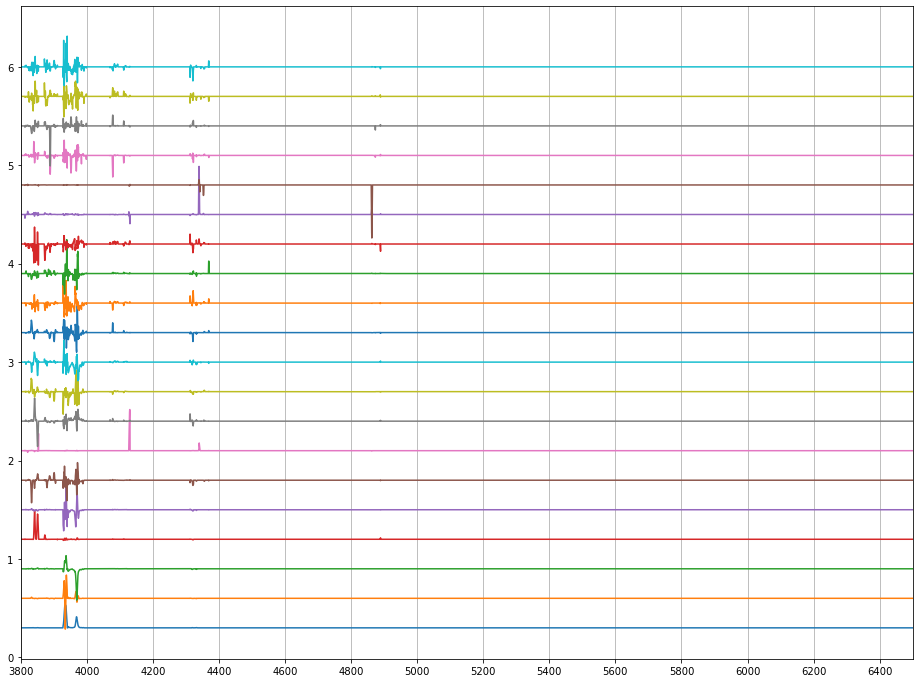

In [68]:
ds.plot_V(nMSv, top=20)